# Style Transfer with Convolutional Neural Networks

In [148]:
import torchvision.models as models
import torch
import numpy as np
import torch.nn as nn
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
%matplotlib inline

# Loss functions

In [8]:
vgg = models.vgg16(pretrained=True)
mse = nn.MSELoss()

## Content Loss

### Content Image

torch.Size([3, 224, 224])


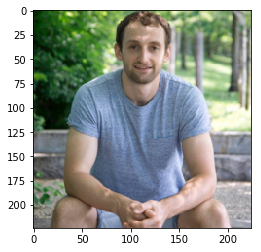

In [17]:
content_image = U.get_image(2, None)
print(content_image.size())
U.imshow(content_image)

In [143]:
#all conv indexes [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
selected_convolutional_indexes = [2, 7, 10,19]
module_lists = [list(vgg.features.children())[:index+1] for index in  selected_convolutional_indexes]
content_models = [ U.convert_to_average_pooling(modules) for modules in module_lists ]

def content_loss(model, generated_image, content_image):
    pred = model.forward(generated_image.unsqueeze(0))
    t = model.forward(content_image.unsqueeze(0))
    t = Variable(t.data)
    return mse(pred, t) * 1

def content_loss_and_gradients(gen_img, content_image):
    prediction = Variable(gen_img, requires_grad= True)                                                         
    loss_amt = sum([ content_loss(model, prediction, content_image) for model in content_models ])
    loss_amt.backward()                                                                                                                        
    content_gradients = prediction.grad.data.numpy().flatten().astype(np.float64)                                                                      
    c_loss = loss_amt.data.numpy().astype(np.float64)
    return c_loss, content_gradients

## Style Loss

### Style Image

torch.Size([3, 224, 224])


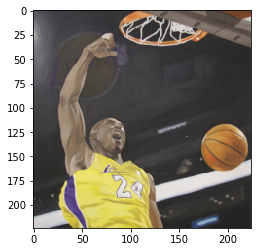

In [105]:
style_image = U.get_image(6,84)
print(style_image.size())
U.imshow(style_image)

In [106]:
#all conv indexes [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
selected_convolutional_indexes = [2, 7, 10,19]
module_lists = [list(vgg.features.children())[:index+1] for index in  selected_convolutional_indexes]
conv_layer_models = [ U.convert_to_average_pooling(modules) for modules in module_lists ]

In [142]:
def gram_matrix(x):
    batch_size = x.size()[0]
    height  = x.size()[1]
    width = x.size()[2]
    chan = x.size()[3]
    flattened_channels = x.resize(batch_size, chan, width * height)
    g_matrix = flattened_channels[0].matmul(flattened_channels[0].transpose(1,0)).unsqueeze(0) / x.nelement() * 150
    return g_matrix

def style_loss(model, generated_image_layer, style_image_layer):
    pred = model.forward(generated_image_layer.unsqueeze(0))
    t = model.forward(style_image_layer.unsqueeze(0))
    t = Variable(t.data)
    return mse(gram_matrix(pred), gram_matrix(t))


def style_loss_and_gradients(gen_image, style_image):
    prediction = Variable(gen_image, requires_grad= True)
    loss_amt = sum([ style_loss(model, prediction, Variable(style_image)) for model in conv_layer_models ])
    loss_amt.backward()                                                                                                                        
    style_gradients = prediction.grad.data.numpy().flatten().astype(np.float64)                                                                      
    s_loss = loss_amt.data.numpy().astype(np.float64)
    return s_loss, style_gradients

# Minimize noise based on vgg output

In [114]:
from scipy.optimize import fmin_l_bfgs_b 

In [115]:
class StyleTransfer():
    def __init__(self, style_image, content_image):
        self.style_image = style_image
        self.content_image = content_image
                
    def loss_fn(self, flattened_image):
        predicted_image = torch.Tensor(flattened_image.reshape(content_image.size()))
        c_loss, content_gradients = content_loss_and_gradients(predicted_image, self.content_image)
        s_loss, style_gradients = style_loss_and_gradients(predicted_image, self.style_image)
        print("s_loss ", s_loss)
        print("c_loss ", c_loss)
        return s_loss + c_loss,  style_gradients + content_gradients

In [116]:
noise_tensor = torch.rand(3,224, 224) - 0.5
import pdb
def transfer_style(transfer_class, maxfun, iterations, starting_image):
    gen_image = starting_image.numpy().flatten()
    for i in range(iterations):
        generated_image, min_val, y = fmin_l_bfgs_b(transfer_class.loss_fn, gen_image, maxfun=maxfun)
        print("Epoch "+str(i) + " Loss: " +str(min_val))
        gen_image = generated_image
    return gen_image

In [ ]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 10, 2, noise_tensor)

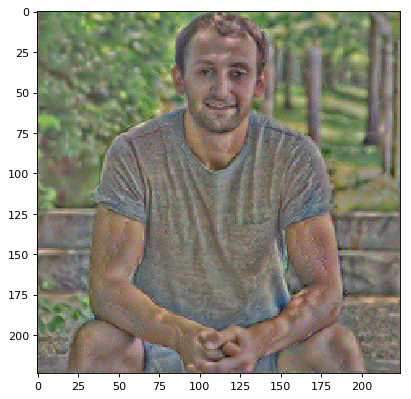

In [112]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [ ]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 10, 1, torch.Tensor(result))

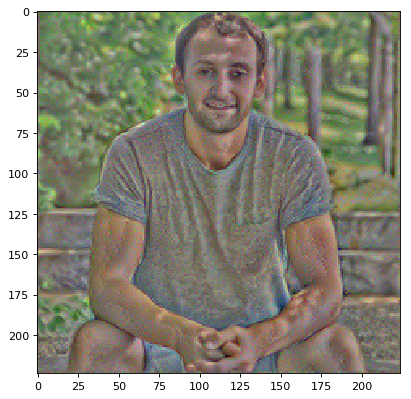

In [119]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))
plt.savefig('./me.jpg')

In [ ]:
result = transfer_style(StyleTransfer(style_image, Variable(content_image)), 10, 1, torch.Tensor(result))

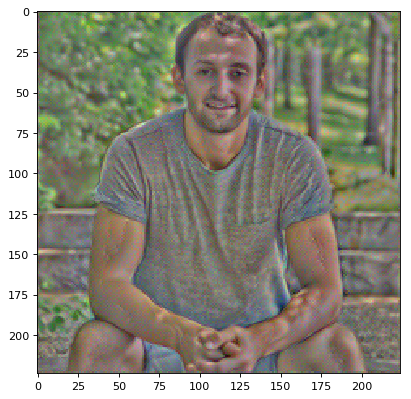

In [122]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

torch.Size([3, 224, 224])


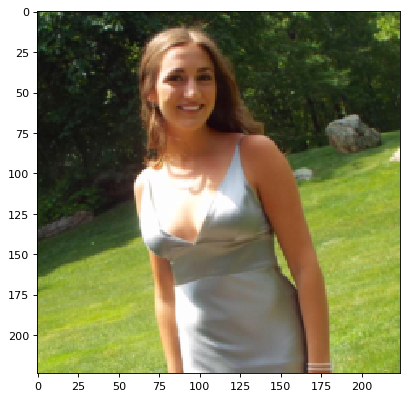

In [147]:
cont_image = U.get_image(0, None)
print(cont_image.size())
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(cont_image))

In [ ]:
result = transfer_style(StyleTransfer(style_image, Variable(cont_image)), 10, 1, torch.Tensor(noise_tensor))

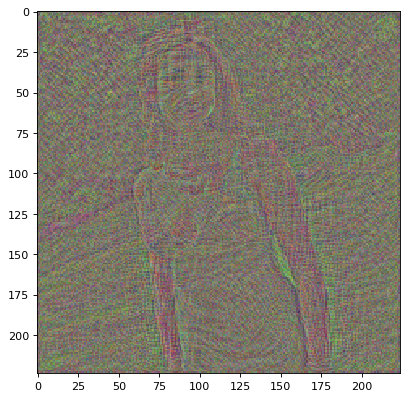

In [129]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [ ]:
result = transfer_style(StyleTransfer(style_image, Variable(cont_image)), 10, 2, torch.Tensor(result))

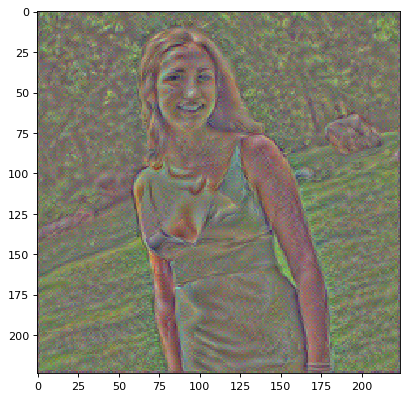

In [133]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [ ]:
result = transfer_style(StyleTransfer(style_image, Variable(cont_image)), 10, 1, torch.Tensor(result))

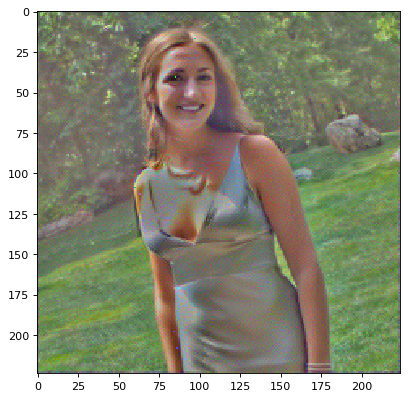

In [137]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [ ]:
result = transfer_style(StyleTransfer(style_image, Variable(cont_image)), 10, 1, torch.Tensor(result))

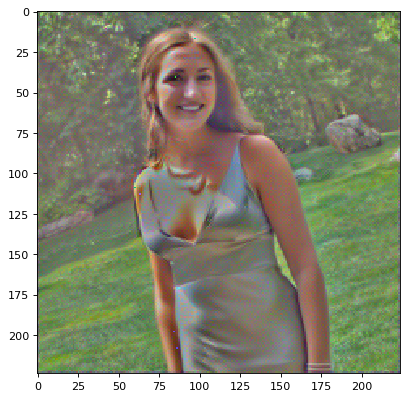

In [141]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))

In [144]:
result = transfer_style(StyleTransfer(style_image, Variable(cont_image)), 10, 1, torch.Tensor(result))

('s_loss ', array([ 11.13760662]))
('c_loss ', array([ 3.03206444]))
('s_loss ', array([ 11.94636726]))
('c_loss ', array([ 3.0996933]))
('s_loss ', array([ 10.99972439]))
('c_loss ', array([ 3.04397655]))
('s_loss ', array([ 10.81028175]))
('c_loss ', array([ 3.06127548]))
('s_loss ', array([ 10.17393494]))
('c_loss ', array([ 3.14373159]))
('s_loss ', array([ 9.30368137]))
('c_loss ', array([ 3.42166734]))
('s_loss ', array([ 8.82679176]))
('c_loss ', array([ 3.57278538]))
('s_loss ', array([ 8.60382271]))
('c_loss ', array([ 3.71488285]))
('s_loss ', array([ 8.1982069]))
('c_loss ', array([ 3.90066147]))
('s_loss ', array([ 7.73257875]))
('c_loss ', array([ 4.09381723]))
('s_loss ', array([ 7.40979862]))
('c_loss ', array([ 4.19186544]))
Epoch 0 Loss: [ 11.60166407]



( 0 ,.,.) = 
  0.3678  0.4624  0.4766  ...   0.5025  0.4186  0.3699
  0.3804  0.4834  0.4842  ...   0.4910  0.5307  0.4641
  0.3503  0.3915  0.6244  ...   0.3681  0.3781  0.4086
           ...             ⋱             ...          
  0.3931  0.4596  0.3446  ...   0.3295  0.4576  0.4296
  0.5343  0.6282  0.5183  ...   0.4601  0.5509  0.3927
  0.3963  0.4581  0.4507  ...   0.3416  0.4765  0.3454

( 1 ,.,.) = 
  0.3734  0.3749  0.4651  ...   0.5834  0.4520  0.3819
  0.4523  0.3953  0.6537  ...   0.6230  0.4880  0.5189
  0.4938  0.5016  0.8051  ...   0.4867  0.5616  0.3988
           ...             ⋱             ...          
  0.5596  0.6666  0.6700  ...   0.5060  0.4641  0.5180
  0.5360  0.5156  0.6813  ...   0.5639  0.5048  0.4888
  0.4308  0.5608  0.4946  ...   0.5263  0.3991  0.3105

( 2 ,.,.) = 
  0.3080  0.4296  0.3802  ...   0.4787  0.4548  0.5084
  0.3533  0.4253  0.4257  ...   0.3515  0.4347  0.3885
  0.3899  0.3388  0.4174  ...   0.3054  0.3158  0.4267
           ...         

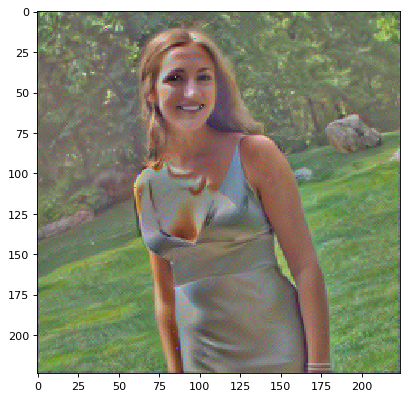

In [149]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
U.imshow(torch.Tensor(result.reshape(content_image.size())))